In [1]:
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output

<function matplotlib.pyplot.show>

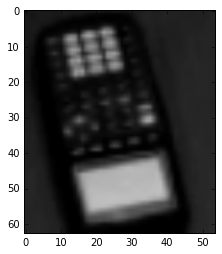

In [2]:
#We obtain the object to be tracked (calculator)
MIN_MATCH_COUNT = 2

cap = cv2.VideoCapture('sources/TOP_cam4Low.avi')
img1 = cv2.imread("sources/calc_image.png",0)  # queryImage
img1show = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)

plt.imshow(img1show)
plt.show


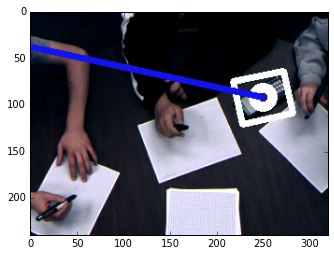

In [ ]:
#Open files to store results
f = open("results/results_calc.csv","w")
f.write("Frame,X,Y,DEGREE,STUDENT\n")

frame = 0

#For each frame
while(cap.isOpened()):

    ret, img2 = cap.read()
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    x = -1
    y = -1
    degreeCorrection = 20
    student = -1

    frame = frame + 1

    #Create a SIFT feature extractor
    try:
        sift = cv2.xfeatures2d.SIFT_create()
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)

        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des1,des2,k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)


        if len(good)>=MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            TM=cv2.estimateRigidTransform(src_pts, dst_pts,False)
            newrow = [0,0,1]
            TM = np.vstack([TM, newrow])

            h,w = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,TM)

            cv2.polylines(img2,[np.int32(dst)],True,(255,255,255),5)
            degree = math.degrees(math.acos(TM[0][0]))
            degree=degree+degreeCorrection

            centerx = (dst[0][0][0]+dst[2][0][0])/2
            centery = (dst[0][0][1]+dst[2][0][1])/2

            x = centerx
            y = centery
            cv2.circle(img2, (np.int32(centerx),np.int32(centery)), 10, (255,255,255),10) 

            #student = 0
            height,width = img2.shape[0],img2.shape[1]
            n = (centery) - (math.tan(math.pi/2-math.acos(TM[0][0])) * (width-centerx))
            x0=(-n)/math.tan(math.radians(90-degree))

            xf = x
            yf = y/2

            if x0>-1 and x0<width+1:
                if x0<180:
                    student = 1
                if x0>179 and x0<701:
                    student = 2
                if x0>700:
                    student = 3
            else:
                if x0<0:
                    student = 1
                if x0>width:
                    student = 3

            cv2.line(img2, (np.int32(centerx),np.int32(centery)), (np.int32(width-x0),0), (237,19,19),5)

        else:
            print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    except:
        pass 

    f.write(str(frame)+','+str(round(x,2))+','+str(round(y,2))+','+str(round(degree,2))+','+str(student)+'\n')

    img2show = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.imshow(img2show)
    plt.show()
    clear_output(wait=True)
    

cap.release()
f.close()